In [9]:
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from keras.utils import pad_sequences
from tensorflow.keras import Model, Input
from tensorflow import keras
from tensorflow.keras.layers import InputLayer, Embedding, SpatialDropout1D, Bidirectional, LSTM, Dense, TimeDistributed
import pandas as pd
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, LayerNormalization, Dense, Dropout, Flatten, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam


## Neural Network Functions

In [11]:
def prepare_dl_training_data(data_frame, sequence_max_len=128):
    """
    Prepare training data for BiLSTM model.

    Args:
        data_frame: DataFrame with training data.
        sequence_max_len: Max sequence length (default: 128).

    Returns:
        X_train: Input sequences (word indices, padded).
        y_train: Target sequences (tag indices, padded).
        vocab_size: Number of unique words.
        tag_count: Number of unique tags.
        word_index: Dict mapping words to indices.
        tag_index: Dict mapping tags to indices.
    """

    # Fill NA values in 'sentence_id' by forward filling
    data_frame["sentence_id"].fillna(method="ffill", inplace=True)

    # Group by 'sentence_id' and aggregate words and tags
    grouped_sentences = data_frame.groupby('sentence_id').apply(lambda s: [(w, t) for w, t in zip(s["words"].tolist(), s["tags"].tolist())]).tolist()

    # Create unique word list with 'ENDPAD'
    unique_words = list(dict.fromkeys(data_frame["words"].tolist())) + ["ENDPAD"]
    vocab_size = len(unique_words)

    # Create unique tag list
    unique_tags = list(dict.fromkeys(data_frame["tags"].tolist()))
    tag_count = len(unique_tags)

    # Map words and tags to indices
    word_index = {word: idx + 1 for idx, word in enumerate(unique_words)}
    tag_index = {tag: idx for idx, tag in enumerate(unique_tags)}

    # Convert sentences and tags to indices
    X_train = [[word_index[word[0]] for word in sentence] for sentence in grouped_sentences]
    y_train = [[tag_index[word[1]] for word in sentence] for sentence in grouped_sentences]

    # Pad sequences
    X_train = pad_sequences(sequences=X_train, maxlen=sequence_max_len, padding="post", value=vocab_size - 1)
    y_train = pad_sequences(sequences=y_train, maxlen=sequence_max_len, padding="post", value=tag_index["O"])

    return X_train, y_train, vocab_size, tag_count, word_index, tag_index


def prepare_dl_testing_data(data_frame, word_index, tag_index, vocab_size, sequence_max_len=128):
    """
    Prepare test data for BiLSTM model.

    Args:
        data_frame: DataFrame with test data.
        word_index: Dict mapping words to indices.
        tag_index: Dict mapping tags to indices.
        sequence_max_len: Max sequence length (default: 128).

    Returns:
        X_test: Input sequences (word indices, padded).
        y_test: Target sequences (tag indices, padded).
    """

    # Fill NA values in 'sentence_id' by forward filling
    data_frame["sentence_id"].fillna(method="ffill", inplace=True)

    # Group by 'sentence_id' and aggregate words and tags
    grouped_sentences = data_frame.groupby('sentence_id').apply(lambda s: [(w, t) for w, t in zip(s["words"].tolist(), s["tags"].tolist())]).tolist()

    # Convert sentences to word indices
    X_test = [[word_index.get(word[0], 0) for word in sentence] for sentence in grouped_sentences]
    y_test = [[tag_index[word[1]] for word in sentence] for sentence in grouped_sentences]

    # Pad sequences
    X_test = pad_sequences(sequences=X_test, maxlen=sequence_max_len, padding="post", value=vocab_size - 1)
    y_test = pad_sequences(sequences=y_test, maxlen=sequence_max_len, padding="post", value=tag_index["O"])

    return X_test, y_test



def compute_accuracy(true_labels, predicted_labels):
    """
    Calculate accuracy excluding 'O' tags.

    Args:
        true_labels: List of true tags.
        predicted_labels: List of predicted tags.

    Returns:
        Accuracy score.
    """

    indices = [index for index, label in enumerate(true_labels) if label != 0]
    true_filtered = [true_labels[i] for i in indices]
    predicted_filtered = [predicted_labels[i] for i in indices]

    return accuracy_score(true_filtered, predicted_filtered)


def evaluate_dl(true_labels, predicted_labels, reverse_tag_index):
    """
    Evaluate predictions and display metrics and confusion matrix.

    Args:
        true_labels: List of true tags.
        predicted_labels: List of predicted tags.
        reverse_tag_index: Dict mapping tag indices to tags.

    Returns:
        None
    """

    accuracy = compute_accuracy(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')

    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=reverse_tag_index.values(), yticklabels=reverse_tag_index.values())
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


def predict_dl(model, X_input):
    """
    Predict labels using the BiLSTM model.

    Args:
        model: BiLSTM model.
        X_input: Input data.

    Returns:
        Predicted labels.
    """

    y_pred = model.predict(X_input)
    y_pred = np.argmax(y_pred, axis=-1)
    y_pred[y_pred > 16] = 16

    return y_pred


## Model Implementations

In [12]:
def build_BiLSTM_model(vocab_size, sequence_max_len=128):
    """
    Build a BiLSTM model.

    Args:
        vocab_size: Number of unique words.
        sequence_max_len: Max sequence length (default: 128).

    Returns:
        model: Compiled BiLSTM model.
    """

    model = Sequential()
    model.add(InputLayer(input_shape=(sequence_max_len,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=sequence_max_len, input_length=sequence_max_len))
    model.add(SpatialDropout1D(0.1))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model


from tensorflow.keras.layers import InputLayer, Embedding, SpatialDropout1D, Bidirectional, LSTM, TimeDistributed, Dense, Dropout

def build_better_BiLSTM_model(vocab_size, sequence_max_len=128, embedding_dim=100):
    """
    Build a BiLSTM model.

    Args:
        vocab_size: Number of unique words.
        sequence_max_len: Max sequence length (default: 128).
        embedding_dim: Dimension of the embedding layer (default: 100).

    Returns:
        model: Compiled BiLSTM model.
    """

    model = Sequential()
    model.add(InputLayer(input_shape=(sequence_max_len,)))
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=sequence_max_len))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.3, dropout=0.3)))
    model.add(TimeDistributed(Dense(100, activation="relu")))
    model.add(Dropout(0.3))
    model.add(TimeDistributed(Dense(vocab_size, activation="softmax")))

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    return model


def build_transformer_model(vocab_size, num_tags, max_len=128, embed_dim=128, num_heads=4, ff_dim=128):
    """
    Build a Transformer model.

    Args:
        vocab_size: Number of unique words.
        num_tags: Number of unique tags.
        max_len: Max sequence length (default: 128).
        embed_dim: Embedding dimension (default: 128).
        num_heads: Number of attention heads (default: 4).
        ff_dim: Feed-forward dimension (default: 128).

    Returns:
        model: Compiled Transformer model.
    """
    inputs = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len)(inputs)

    # Transformer Encoder block
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(embedding_layer, embedding_layer)
    attention_output = Dropout(0.1)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
    
    feed_forward_output = Dense(ff_dim, activation="relu")(attention_output)
    feed_forward_output = LayerNormalization(epsilon=1e-6)(feed_forward_output)

    # Flatten the output and add a dense layer with num_tags output units
    flatten_output = Flatten()(feed_forward_output)
    dense_output = Dense(num_tags * max_len, activation="softmax")(flatten_output)
    final_output = Reshape((max_len, num_tags))(dense_output)

    model = Model(inputs=inputs, outputs=final_output)
    model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# Data preparation

In [13]:
train = pd.read_csv("data/train_data_ner.csv")
test = pd.read_csv("data/test_data_ner.csv")

In [14]:
sentences_train, tags_train, num_words, num_tags, word2idx, tag2idx = prepare_dl_training_data(train)
sentences_test, tags_test = prepare_dl_testing_data(test, word2idx, tag2idx,num_words)

/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_59730/2238465369.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame["sentence_id"].fillna(method="ffill", inplace=True)
/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_59730/2238465369.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_frame["sentence_id"].fillna(method="ffill", inplace=True)
/var/folders/yb/mm0hrmlx3g9dv10c735753m00000gn/T/ipykernel_

## Model Building & Training

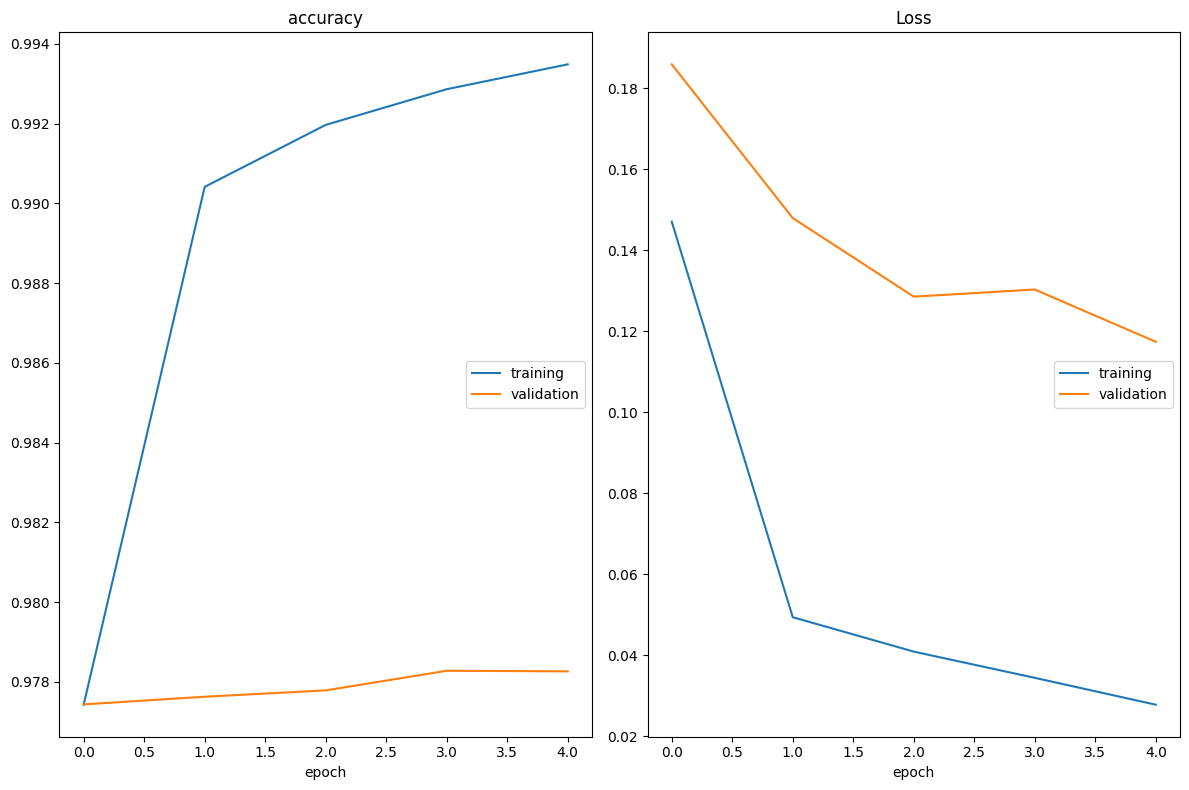

accuracy
	training         	 (min:    0.977, max:    0.993, cur:    0.993)
	validation       	 (min:    0.977, max:    0.978, cur:    0.978)
Loss
	training         	 (min:    0.028, max:    0.147, cur:    0.028)
	validation       	 (min:    0.117, max:    0.186, cur:    0.117)

Epoch 5: val_loss improved from 0.12857 to 0.11742, saving model to bilstm.weights.h5
1199/1199 [==============================] - 377s 314ms/step - loss: 0.0278 - accuracy: 0.9935 - val_loss: 0.1174 - val_accuracy: 0.9783


In [16]:

logdir = "log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# ModelCheckpoint callback to save the best model weights
chkpt = ModelCheckpoint("bilstm.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# EarlyStopping callback to stop training early if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

# Define a list of callbacks to be used during training
callbacks = [PlotLossesCallback(), chkpt, early_stopping, tensorboard_callback]

# Create the BiLSTM model
bilstm_model = build_BiLSTM_model(num_words)

# Train the model
history = bilstm_model.fit(
    x=sentences_train,
    y=tags_train,
    validation_data=(sentences_test, tags_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# # Load the TensorBoard extension
# %load_ext tensorboard

# # Launch TensorBoard to visualize the logs
# %tensorboard --logdir log

In [20]:

logdir = "log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# ModelCheckpoint callback to save the best model weights
chkpt = ModelCheckpoint("better_bilstm.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# EarlyStopping callback to stop training early if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

# Define a list of callbacks to be used during training
callbacks = [PlotLossesCallback(), chkpt, early_stopping, tensorboard_callback]

# Create the BiLSTM model
better_bilstm_model = build_better_BiLSTM_model(num_words)

# Train the model
history = better_bilstm_model.fit(
    x=sentences_train,
    y=tags_train,
    validation_data=(sentences_test, tags_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# # Load the TensorBoard extension
# %load_ext tensorboard

# # Launch TensorBoard to visualize the logs
# %tensorboard --logdir log

Epoch 1/10
1199/1199 [==============================] - ETA: 0s - loss: 0.2741 - accuracy: 0.9749

KeyboardInterrupt: 

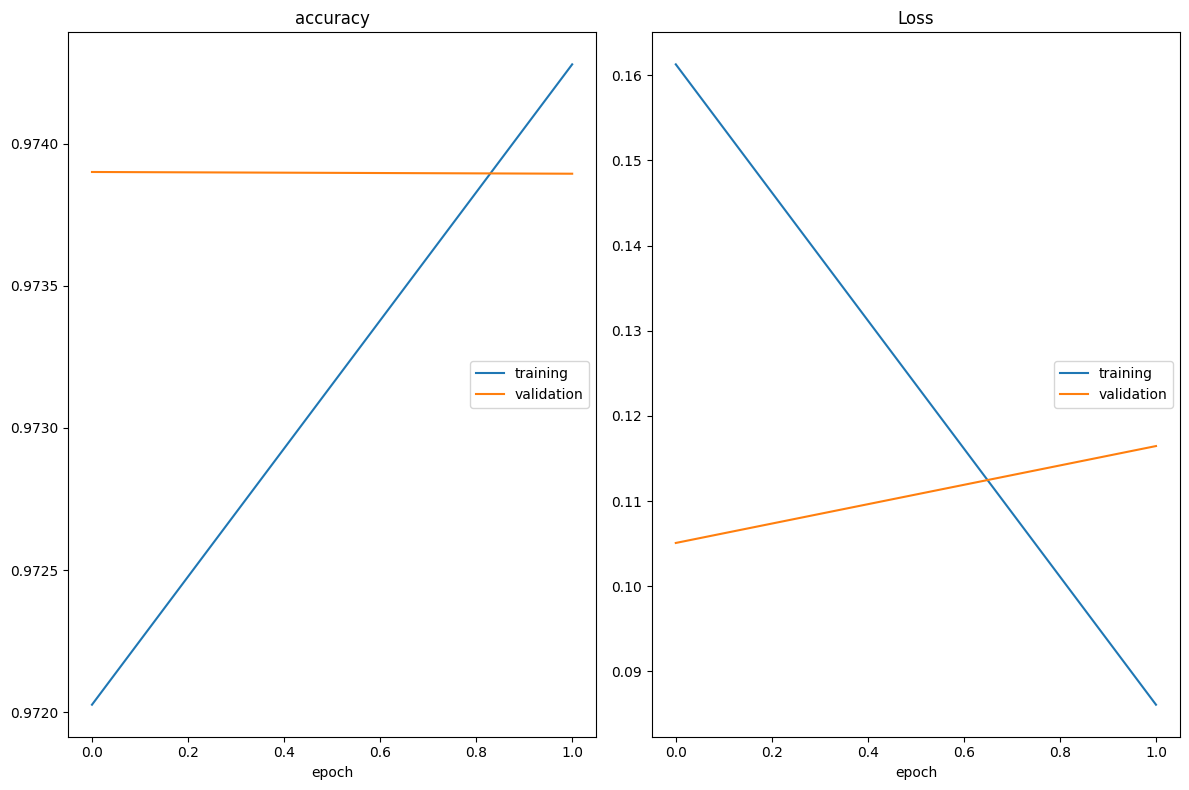

accuracy
	training         	 (min:    0.972, max:    0.974, cur:    0.974)
	validation       	 (min:    0.974, max:    0.974, cur:    0.974)
Loss
	training         	 (min:    0.086, max:    0.161, cur:    0.086)
	validation       	 (min:    0.105, max:    0.116, cur:    0.116)

Epoch 2: val_loss did not improve from 0.10508
1199/1199 [==============================] - 368s 307ms/step - loss: 0.0861 - accuracy: 0.9743 - val_loss: 0.1165 - val_accuracy: 0.9739


In [21]:

logdir = "log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# ModelCheckpoint callback to save the best model weights
chkpt = ModelCheckpoint("transformer_model.weights.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

# EarlyStopping callback to stop training early if validation accuracy doesn't improve
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)

# Define a list of callbacks to be used during training
callbacks = [PlotLossesCallback(), chkpt, early_stopping, tensorboard_callback]

# Create the BiLSTM model
transformer_model = build_transformer_model(num_words, num_tags)

# Train the model
history = transformer_model.fit(
    x=sentences_train,
    y=tags_train,
    validation_data=(sentences_test, tags_test),
    batch_size=32,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

# Load the TensorBoard extension
%load_ext tensorboard

# Launch TensorBoard to visualize the logs
%tensorboard --logdir log

## Testing

1199/1199 [==============================] - 64s 54ms/step
Accuracy: 0.0396
F1 Score: 0.9664


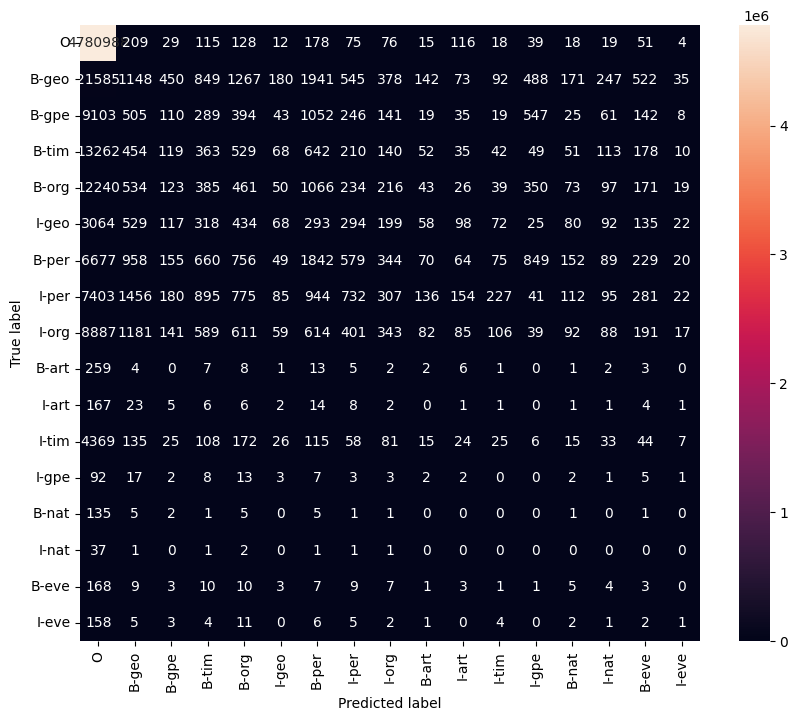

In [22]:
# sentences_test, tags_test
tag_dict_rev = {v: k for k, v in tag2idx.items()}

y_train_pred = predict_dl(transformer_model, sentences_train)
evaluate_dl(tags_train.flatten().tolist(), y_train_pred.flatten().tolist(), tag_dict_rev)

1199/1199 [==============================] - 59s 49ms/step
Accuracy: 0.1976
F1 Score: 0.9718


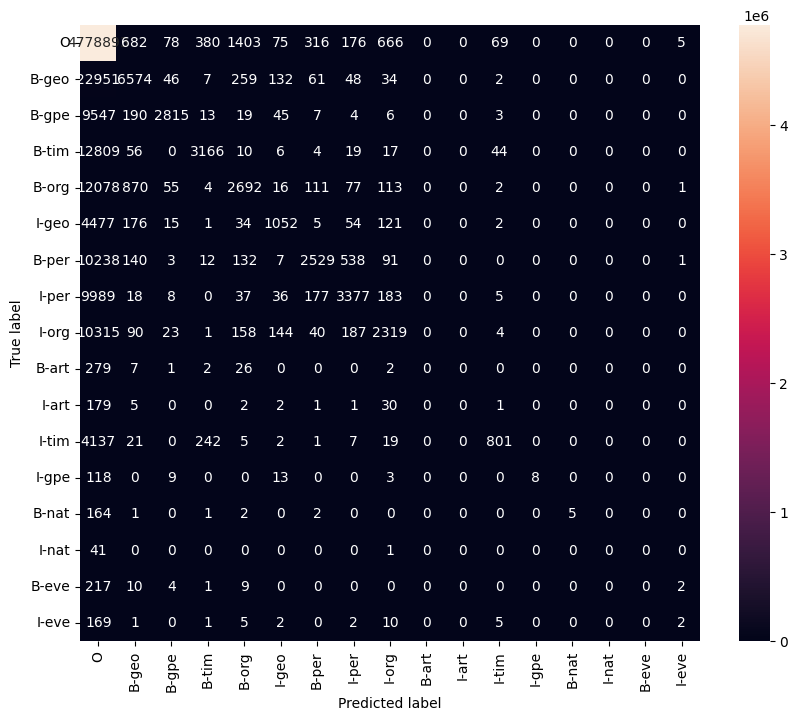

In [18]:

y_test_pred = predict_dl(bilstm_model, sentences_test)
# train


evaluate_dl(tags_test.flatten().tolist(), y_test_pred.flatten().tolist(), tag_dict_rev)